## Practical Machine Learning : Recipe Sales Forecast

   
**Version : 1**

---------------------------------

## <a id='1'>1. Import all the necessary libraries to run our Analysis </a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from numpy import exp
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew 
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
from yellowbrick.regressor import ResidualsPlot
import math
import sklearn.metrics as metrics
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold ,GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')

--------------------------------------

## <a id='2'>2. Import the dataset to run our Analysis </a>

In [4]:
train = pd.read_csv("train_data_cleaned.csv")

test = pd.read_csv("test_data_cleaned.csv")

- Create a copy of the dataset to training dataset inoder to retain the original values

In [5]:

train1 = train.copy()


- Unified the recipe id to build the base data

In [6]:
FM_BASE = train1[['recipe_id','sales']]

FM_table = FM_BASE.groupby('recipe_id').agg({'recipe_id': lambda x: len(x),
                                                'sales': lambda x: x.sum()})
FM_table.rename(columns={ 'recipe_id': 'frequency',
                         'sales': 'sales_sum'}, inplace=True)
FM_table.reset_index()

FM_table['Avg_sales'] = FM_table['sales_sum']/FM_table['frequency']

Uni_train1 = train1.drop(['year_week','sales'], axis = 1) 

Uni_train1 = Uni_train1.drop_duplicates()


In [7]:
Uni_train2 = pd.merge(Uni_train1, FM_table, on='recipe_id', how='inner')

In [8]:
Uni_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1931 entries, 0 to 1930
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   recipe_id                         1931 non-null   int64  
 1   recipe_name                       1931 non-null   object 
 2   product_type                      1931 non-null   object 
 3   calories                          1926 non-null   float64
 4   carbs                             1919 non-null   float64
 5   cooking_time                      1864 non-null   object 
 6   cuisine                           1417 non-null   object 
 7   description                       1927 non-null   object 
 8   difficulty                        1922 non-null   object 
 9   dish_type                         1670 non-null   object 
 10  heat_level                        1595 non-null   object 
 11  fat                               1919 non-null   float64
 12  is_cla


## <a id='3'>3. Data Preprocessing  </a>

- Check for missing values and descriptive features

In [9]:
# Missing data

total = Uni_train2.isnull().sum().sort_values(ascending=False)
percent = (Uni_train2.isnull().sum()/Uni_train2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(2)

,Total,Percent
cooking_tip,1931,1.000000
protein_cuts,559,0.289487


In [10]:
Uni_train3 = Uni_train2.drop(['cooking_tip','description','is_classic','carbs_content','course_type','percentage_of_local_ingredients'],axis=1)

##### We can drop cooking_tip because it has more than 80% of missing values also there are certain features which cannot be used for buidling the model as they have plenty of categories which will lead to over fitting and also they require business inputs

- Check the categorical & numerical features within the dataset

In [11]:
object_columns_df = Uni_train3.select_dtypes(include=['object'])
numerical_columns_df =Uni_train3.select_dtypes(exclude=['object'])

#### Figure out  missing values in  categorical feature

In [12]:
null_counts = object_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
recipe_name        0
product_type       0
cooking_time      67
cuisine          514
difficulty         9
dish_type        261
heat_level       336
preferences      278
dish_types       324
seasons          541
protein_types    321
meta_tags        434
protein_cuts     559
dtype: int64


- Features like cooking_time,cuisine,seasons,protein_cuts and others have certain missing values and will require imputation

#### Figure out  missing values in  Numerical feature

In [13]:
null_counts = numerical_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
recipe_id                            0
calories                             5
carbs                               12
fat                                 12
number_of_ingredients_per_recipe     0
proteins                            12
frequency                            0
sales_sum                            0
Avg_sales                            0
dtype: int64


-------------------------------------------

- Filling the missing values with refrencing from recipe_name column , we will be able to derive most of the values for dish_type , meta_tags , protein_cuts. These feature should have some imapct on the sales of receipe.

In [14]:
def func(a):
    if "fish" in a:
        return "fish"
    if "Chicken" in a:
        return "meat"
    if "Pork" in a:
        return "meat"
    if "Carbonara" in a:
        return "veggie"
    if "Potato" in a:
        return "veggie"
    if "Steaks" in a:
        return "meat" 
    if "Cauliflower" in a:
        return "veggie"
    if "Mushroom" in a:
        return "veggie"
    if "Shrimp" in a:
        return "meat"
    if "Mozzarella" in a:
        return "veggie"
    if "Ravioli" in a:
        return "veggie"
    if "Pork" in a:
        return "meat"
    if "Tortelloni" in a:
        return "veggie"
    if "Sausage" in a:
        return "meat"
    if "Flatbread" in a:
        return "veggie"
    if "Coconut-Peanut" in a:
        return "veggie"
    if "Grass-Fed" in a:
        return "veggie"
    if "Vegetables" in a:
        return "veggie"
    if "Cake" in a:
        return "wine_and_dessert"
    if "Cauliflower" in a:
        return "veggie"
    if "Beef" in a:
        return "meat"
    if "Turkey" in a:
        return "meat"
    if "Lasagna" in a:
        return "veggie"
    if "Veggie" in a:
        return "veggie"
    if "Cookies" in a:
        return "wine_and_dessert"
    if "Enchiladas" in a:
        return "veggie"
    if "Beans" in a:
        return "veggie"
    if "Ramen" in a:
        return "veggie"
    if "Meatballs" in a:
        return "meat"   
    if "Salmon" in a:
        return "fish"
    if "Cauliflower" in a:
        return "veggie"
    if "Tofu" in a:
        return "veggie"
    if "Cod" in a:
        return "veggie"
    if "Drumsticks" in a:
        return "meat"
    if "Gnocchi" in a:
        return "veggie"
    if "Oat" in a:
        return "veggie"
    if "Risotto" in a:
        return "veggie"
    if "Udon" in a:
        return "veggie"
    if "Gnocchi" in a:
        return "veggie"
    if "Gnocchi" in a:
        return "veggie"
    if "Steak" in a:
        return "meat"
    if "Steakhouse" in a:
        return "meat" 
    if "Red Curry" in a:
        return "veggie"
    if "Nachos" in a:
        return "veggie"
    if "Stir-Fried" in a:
        return "veggie"
    if "Bacon" in a:
        return "meat"
    if "Mother's" in a:
        return "meat"
    else:
        return a
Uni_train3["dish_test"] = Uni_train3.recipe_name.apply(lambda x: func(x))

Uni_train3['dish_type'] = Uni_train3['dish_type'].fillna(0)

Uni_train3['dish_type'] = Uni_train3.apply(lambda x: x['dish_test'] if x['dish_type']== 0 else x['dish_type'], axis=1)

Uni_train3 = Uni_train3.drop(['dish_test',],axis=1)


In [15]:
def func1(a):
    
    if "Stew" in a:
        return "healthy_choice,quick"
    if "Spiced Chicken" in a:
        return "kid_friendly"
    if "Steak" in a:
        return "healthy_choice,quick"
    if "Ravioli" in a:
        return "kid_friendly,quick"
    if "Creamy Carbonara" in a:
        return "kid_friendly,quick"
    if "Garlic Chicken" in a:
        return "thighs_boneless_skinless" 
    if "Chicken" in a:
        return "healthy_choice,quick"
    if "Steak & Crispy" in a:
        return "quick"
    if "Drumsticks" in a:
        return "kid_friendly"
    if "Enchiladas" in a:
        return "kid_friendly,quick"
    if "Bangers and Mash" in a:
        return "kid_friendly"
    if "Burger" in a:
        return "kid_friendly"
    if "Pizza" in a:
        return "kid_friendly"
    if "Macaroni" in a:
        return "kid_friendly"
    if "Meatloaves" in a:
        return "kid_friendly"
    if "Cheeseburgers" in a:
        return "kid_friendly"
    if "Flatbread" in a:
        return "kid_friendly"
    if "Vegetables" in a:
        return "healthy_choice,quick"
    if "Oat" in a:
        return "healthy_choice,quick"
    if "Cauliflower" in a:
        return "healthy_choice,quick"
    if "Sausage" in a:
        return "healthy_choice,quick"
    if "Cookies" in a:
        return "kid_friendly"
    if "Udon" in a:
        return "healthy_choice,quick"
    if "Gnocchi" in a:
        return "healthy_choice,quick"
    if "Ramen" in a:
        return "healthy_choice,quick"
    if "Cake" in a:
        return "kid_friendly"
    if "Veggie" in a:
        return "healthy_choice,quick"
    if "Spinach" in a:
        return "healthy_choice,quick"
    
    if "Meatballs" in a:
        return "healthy_choice,quick"
    if "Beef" in a:
        return "healthy_choice,quick"
    if "Salmon" in a:
        return "healthy_choice"
    if "Tofu" in a:
        return "healthy_choice,quick"
    if "Carrot" in a:
        return "healthy_choice,quick"
    if "Beef" in a:
        return "healthy_choice,quick"
    if "Ratatouille" in a:
        return "kid_friendly"
    if "Seared Sirloin Steaks" in a:
        return "quick,kid_friendly"
    if "Potato" in a:
        return "quick,kid_friendly"
    if "Pie" in a:
        return "quick"
    if "Pork" in a:
        return "healthy_choice,quick"
    if "Salad" in a:
        return "healthy_choice,quick"
    if "Soup" in a:
        return "healthy_choice,quick"
    if "Vegetarian" in a:
        return "healthy_choice"
    if "Shrimp" in a:
        return "kid_friendly,healthy_choice,quick"
    if "Mozzarella" in a:
        return "quick"
    if "Bean" in a:
        return "quick"
    if "Turkey" in a:
        return "healthy_choice,quick"
    if "Tacos" in a:
        return "kid_friendly,quick"
    if "Noodles" in a:
        return "healthy_choice"
    if "Tortelloni" in a:
        return "kid_friendly,quick"
    if "Herbed" in a:
        return "healthy_choice"
    if "Baked Cheesy" in a:
        return "kid_friendly,quick"
    if "Primavera" in a:
        return "quick"
    if "Lasagna" in a:
        return "kid_friendly,quick"
    if "Day" in a:
        return "healthy_choice,quick"
    if "Cod" in a:
        return "quick"
    if "Pasta" in a:
        return "quick"
    if "Risotto" in a:
        return "kid_friendly,quick"
    else:
        return 0
Uni_train3["meta_t"] = Uni_train3.recipe_name.apply(lambda x: func1(x))

Uni_train3['meta_tags'] = Uni_train3['meta_tags'].fillna(0)

Uni_train3['meta_tags'] = Uni_train3.apply(lambda x: x['meta_t'] if x['meta_tags']== 0 else x['meta_tags'], axis=1)

Uni_train3 = Uni_train3.drop(['meta_t',],axis=1)


In [16]:
def func2(a):
    
    if "Chicken" in a:
        return "breast"
    if "Beans" in a:
        return "kid_friendly"
    if "Bangers" in a:
        return "sausage"
    if "Thighs" in a:
        return "thighs_boneless_skinless"
    if "Chops" in a:
        return "chops_boneless"
    if "Pizza" in a:
        return "no_cut" 
    if "Steak" in a:
        return "steak"
    if "Spiced Chicken" in a:
        return "no_cut"
    if "Drumsticks" in a:
        return "drumsticks"
    if "Steak" in a:
        return "steak"
    if "Chicken Thighs" in a:
        return "thighs_bone_in_skin_on"
    if "Tso's" in a:
        return "no_cut"
    if "Patties" in a:
        return "burger_patty"
    if "Patties" in a:
        return "burger_patty"
    if "Steak" in a:
        return "steak"
    if "Turkey" in a:
        return "ground_mince"
    if "Sweet Potatoes" in a:
        return "no_cut"
    if "Pork Chops" in a:
        return "chops_boneless"
    if "Pork Cutlets" in a:
        return "tenderloin"
    if "Herb" in a:
        return "steak"
    if "Steak" in a:
        return "steak"
    if "Veggie" in a:
        return "no_cut"
    if "Meatballs" in a:
        return "ground_mince"
    
    else:
        return 0
Uni_train3["protein_c"] = Uni_train3.recipe_name.apply(lambda x: func2(x))

Uni_train3['protein_cuts'] = Uni_train3['protein_cuts'].fillna(0)

Uni_train3['protein_cuts'] = Uni_train3.apply(lambda x: x['protein_c'] if x['protein_cuts']== 0 else x['protein_cuts'], axis=1)

Uni_train3 = Uni_train3.drop(['protein_c',],axis=1)

Uni_train3['protein_cuts']=Uni_train3['protein_cuts'].replace(0, np.nan)

columns_None = ['protein_cuts']
Uni_train3[columns_None]= Uni_train3[columns_None].fillna('no_cut')



- Fill missing values for some other categories using its own most frequent value

In [18]:

columns_with_NA = ['product_type','cooking_time','seasons']

Uni_train3[columns_with_NA] = Uni_train3[columns_with_NA].fillna(Uni_train3.mode().iloc[0])

In [19]:
object_columns_df = Uni_train3.select_dtypes(include=['object'])

null_counts = object_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
recipe_name        0
product_type       0
cooking_time       0
cuisine          514
difficulty         9
dish_type          0
heat_level       336
preferences      278
dish_types       324
seasons            0
protein_types    321
meta_tags          0
protein_cuts       0
dtype: int64


- For the other features I feel we require business inputs/knowledge to be used in the model for example heat_level,protein_types,dish_types,preferences.

-------------------------

### Now we will deal with the numerical features 

- Since these features have very few missing values, we will impute them using median

In [20]:

Uni_train3['calories'] = Uni_train3['calories'].fillna(729)
Uni_train3['carbs'] = Uni_train3['carbs'].fillna(63)
Uni_train3['fat'] = Uni_train3['fat'].fillna(37)
Uni_train3['proteins'] = Uni_train3['proteins'].fillna(35)

In [21]:
numerical_columns_df =Uni_train3.select_dtypes(exclude=['object'])
null_counts = numerical_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
recipe_id                           0
calories                            0
carbs                               0
fat                                 0
number_of_ingredients_per_recipe    0
proteins                            0
frequency                           0
sales_sum                           0
Avg_sales                           0
dtype: int64


------------------------------------------------


## <a id='4'>4. Exploratory Data Analysis</a>

- Lets create a copy of the original data to retain the values if required

In [22]:
Uni_train4 = Uni_train3.copy()

family      945
2 person    944
z_amazon     30
add_on       12
Name: product_type, dtype: int64

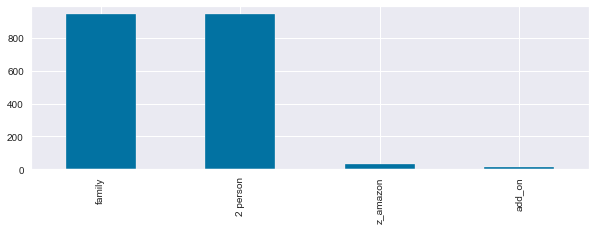

In [23]:
Uni_train4['product_type'].value_counts().plot(kind='bar',figsize=[10,3])
Uni_train4['product_type'].value_counts()

**Observation**

- Mostly Family & 2 person type of products are been ordered. It does give an indication about customer prefrences.We need to have more variety in Add on to increase it sales


time_level_4    1021
time_level_5     797
time_level_3     101
time_level_6      10
time_level_7       2
Name: cooking_time, dtype: int64

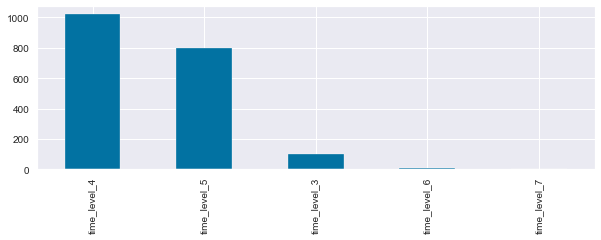

In [24]:
Uni_train4['cooking_time'].value_counts().plot(kind='bar',figsize=[10,3])
Uni_train4['cooking_time'].value_counts()

**Observation**

- Recipe with level_4 of cooking time are mostly New_american ,Italian & Asian. with dish type being meat and are available in all_seasons

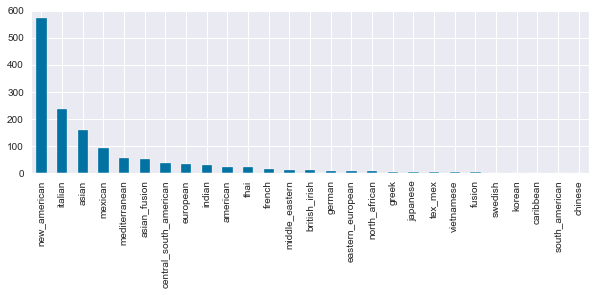

In [25]:
Uni_train4['cuisine'].value_counts().plot(kind='bar',figsize=[10,3])


**Observation**

- Mostly New_american recipe are in demand among the customers with Roasted Chicken & Broccoli and  Seared Steak generating the highest sales

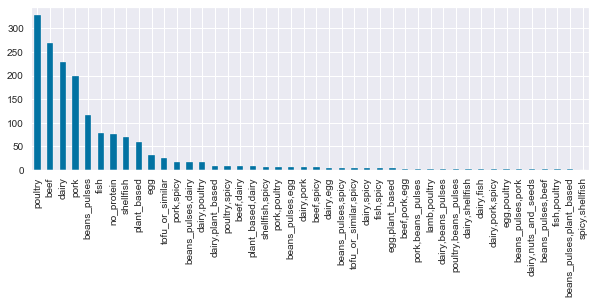

In [26]:
Uni_train4['preferences'].value_counts().plot(kind='bar',figsize=[10,3])

**Observation**

- Mostly poultry & meat Recipes are in demand over the period of time 

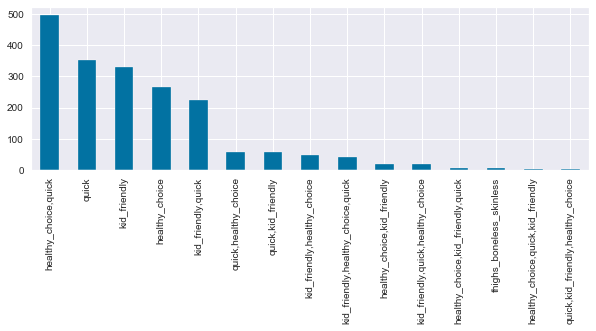

In [27]:


Uni_train4['meta_tags'].value_counts().plot(kind='bar',figsize=[10,3])

**Observation**

- Healthy & Quick recipe have been ordered most of the time , with BBQ Spice Rubbed Chicken , Seared Steak drawing thiggh sales

In [28]:
columns = ['cuisine','heat_level','preferences','dish_types','protein_types']
Uni_train5= Uni_train4.drop(columns, axis=1)

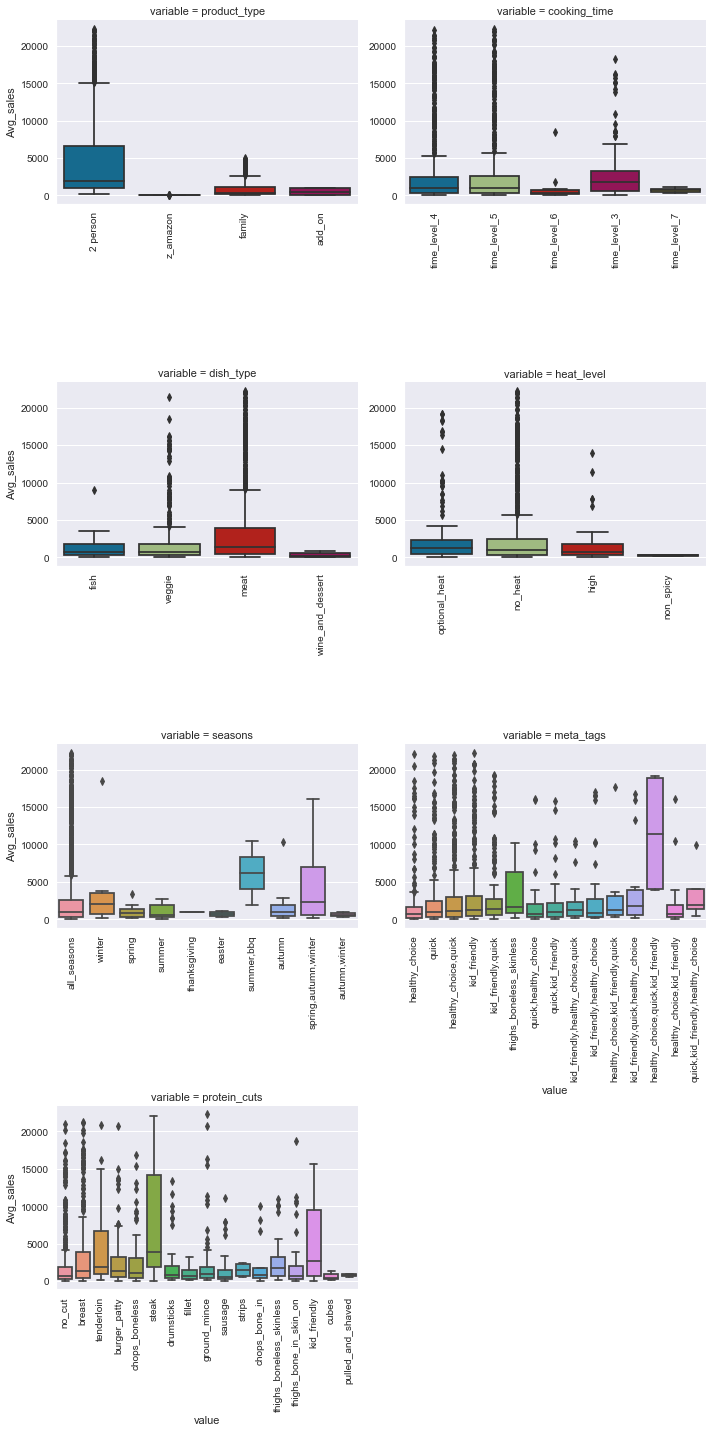

In [29]:
object_columns_df1 = ['product_type', 'cooking_time',
       'dish_type', 'heat_level','seasons', 'meta_tags', 'protein_cuts']

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(Uni_train3, id_vars=['Avg_sales'], value_vars= object_columns_df1)

g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)

g = g.map(boxplot, "value", "Avg_sales")

plt.show();

**Observation**

- Some categories seem to be more diverse with respect to Avg_sales than others , 2 person product_type has big impact on sales with cookiing time at level 4 & 5. These dishes are mostly meat and preferred in autumn and winters


- Healthy choices ,quick & kid_friendly are mostly having high avg sales

--------------------------------

#### Lets try to determine the significant categorical features which may influence the sale

In [30]:
cat_imp = Uni_train3[['product_type', 'cooking_time','cuisine','preferences','dish_type', 'heat_level','seasons', 'protein_types','meta_tags', 'protein_cuts','Avg_sales']]

qualitative = [f for f in cat_imp.columns if cat_imp.dtypes[f] == 'object']


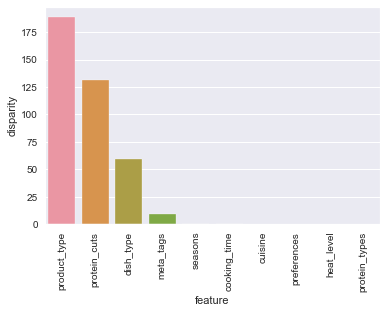

In [31]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['Avg_sales'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(cat_imp)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Here is quick estimation of influence of categorical variable on Avg_sales. For each variable Avg_sales are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal.

----------------------------------

####  We need check 'Avg_sales' and other numerical features along with distribution

In [32]:
quantitative = [f for f in Uni_train3.columns if Uni_train3.dtypes[f] != 'object']
quantitative.remove('sales_sum')
quantitative.remove('recipe_id')

In [33]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(Uni_train3[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


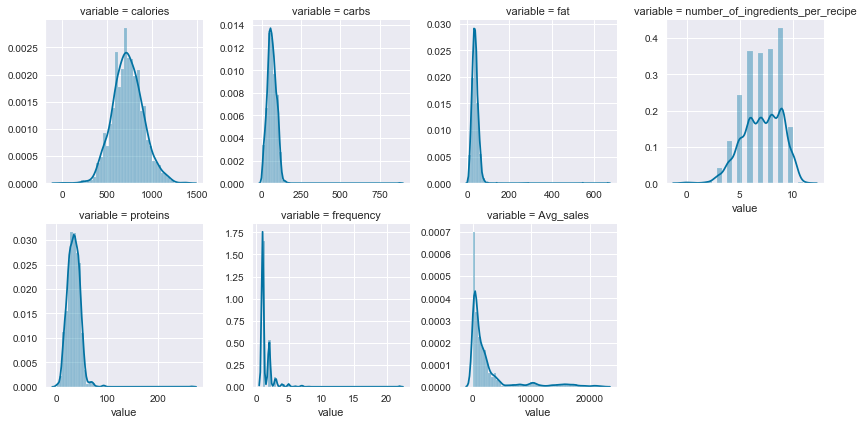

In [34]:
f = pd.melt(Uni_train3, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

- It is apparent that most of the numeric features doesn't follow normal distribution, most independent variables look like good candidates for log transformation so before performing regression they has to be transformed and log transformation may be really helpfull

## <a id='5'>5. Feature Interaction and Influences </a>

#### Scatter plots between 'Avg_Sales' and correlated variables

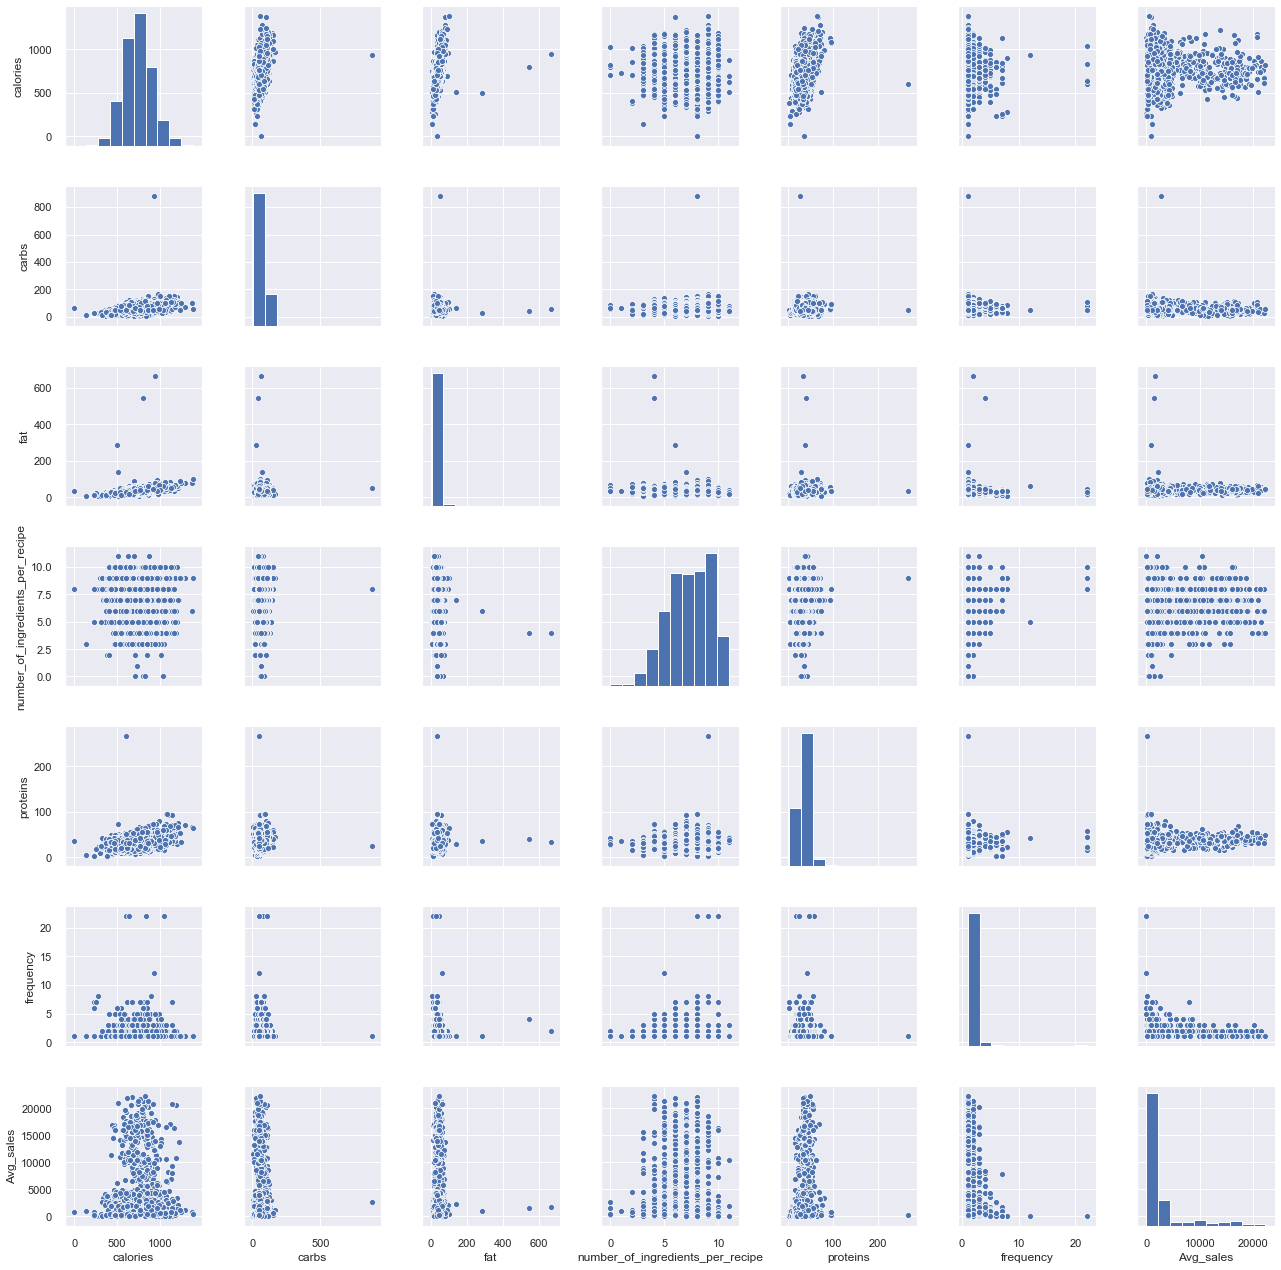

In [35]:
sns.set()
cols = ['calories', 'carbs', 'fat', 'number_of_ingredients_per_recipe', 
'proteins', 'frequency', 'Avg_sales']
sns.pairplot(Uni_train3[cols], size = 2.5)
plt.show();


- One of the figures we may find interesting is the one between 'Avg_sales' and 'calories'. In this figure we can see the dots drawing a cluster with high calories recipe and high sales. Calories and proteins reecipe drawing a linear line, which almost acts like a border.Fats,calories and carbs also share a linear relation. These are the major Ingredients for high sales receipes.


- Around 5-8 ingredients per recipe are mostly preferred by the customers

#### Avg_sales correlation matrix 

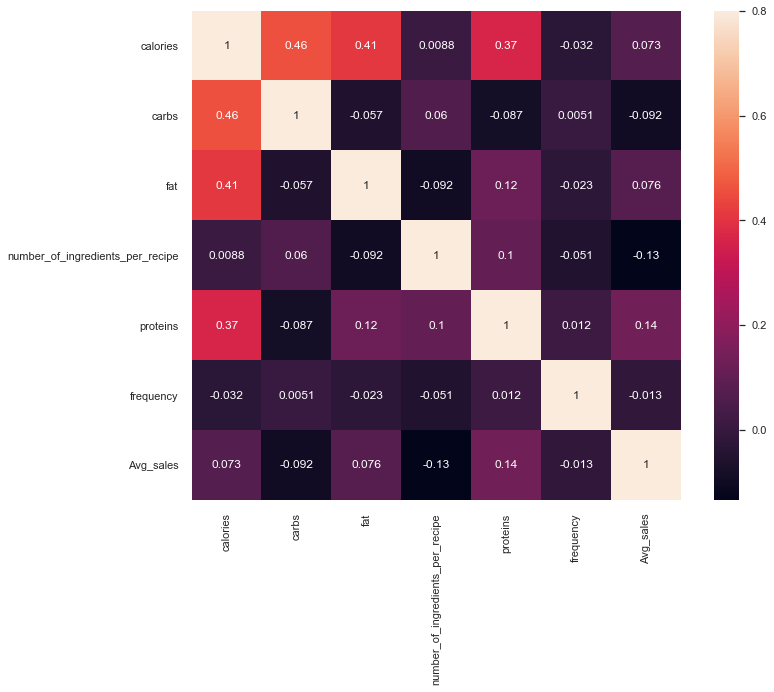

In [36]:

pd.set_option('display.max_columns', 10)

corrmat = Uni_train3[quantitative].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);

**Observation**

As we can see, the multicollinearity still exists in various features, however it is low. The highest correlation is between carbs & calories i.e 46%. Since this correlation is not so significant we will keep these 
feature.
Same logic will be appliicable to calories & fat with 41%. In modeling building we may try to remove them and test the model performance. If the performance improves after removing them, these features will not be considered in the final model.


###  Outlier detection

##### Univariate analysis

In [37]:
def out_std(s, nstd=3.0, return_thresholds=False):

    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]
    
outlier_mask = out_std(Uni_train3['Avg_sales'], nstd=3.0)

# Identify the outliers, notice these values are on both low and high

Uni_train3['Avg_sales'][outlier_mask]

54      16778.000000
101     16317.666667
113     17793.000000
122     16875.000000
128     17925.000000
            ...     
1829    15967.000000
1861    15950.000000
1866    16969.000000
1899    16694.000000
1913    16014.000000
Name: Avg_sales, Length: 73, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1a25016f50>,
 'caps': [<matplotlib.lines.Line2D at 0x1a24fd0910>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a25016410>],
 'medians': [<matplotlib.lines.Line2D at 0x1a244d4fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a244d4850>],
 'means': []}

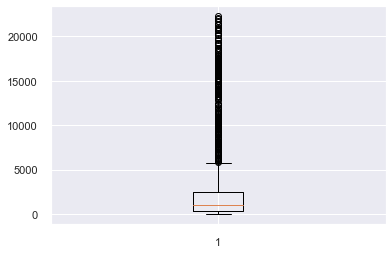

In [38]:
plt.boxplot(Uni_train3.Avg_sales)

- Low range values are similar and not too far from 0.
- High range values are far from 0 and  most of them are above 5300+ 

- We will not remove them since they are natural occuring outliers, In out previous analysis we have observed the sales of meat products are high which can be a reason for these extreme values

#### Bivariate analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


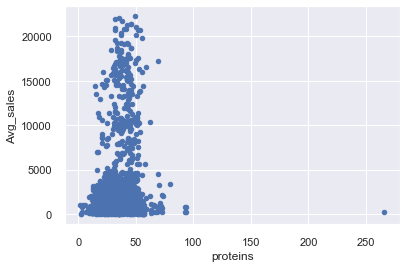

In [39]:

Uni_train3.plot.scatter(x='proteins', y='Avg_sales');


**Observation**


- The one on the bottom right of the same chart do not follow any trends. if required we will get rid of it

-----------------------------

### Since we are done with EDA let validate the Assumptions of Regression before moving to modeling :-
    

#### Normality


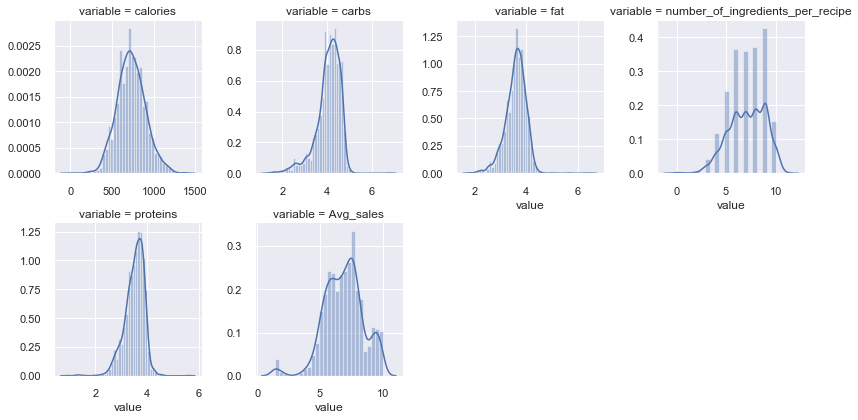

In [40]:
## Features to be transformed 

log_features = ['carbs','fat','proteins','Avg_sales']

train_normal = Uni_train3.copy()

train_normal[log_features]  = np.log1p(train_normal[log_features])

quantative_f = ['calories','carbs','fat','number_of_ingredients_per_recipe','proteins', 'Avg_sales']

f = pd.melt(train_normal, value_vars = quantative_f)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

- After the log transformation all the features seems to have normal distribution. we didn't transform calories since it was already had normal distribution

#### Linearity


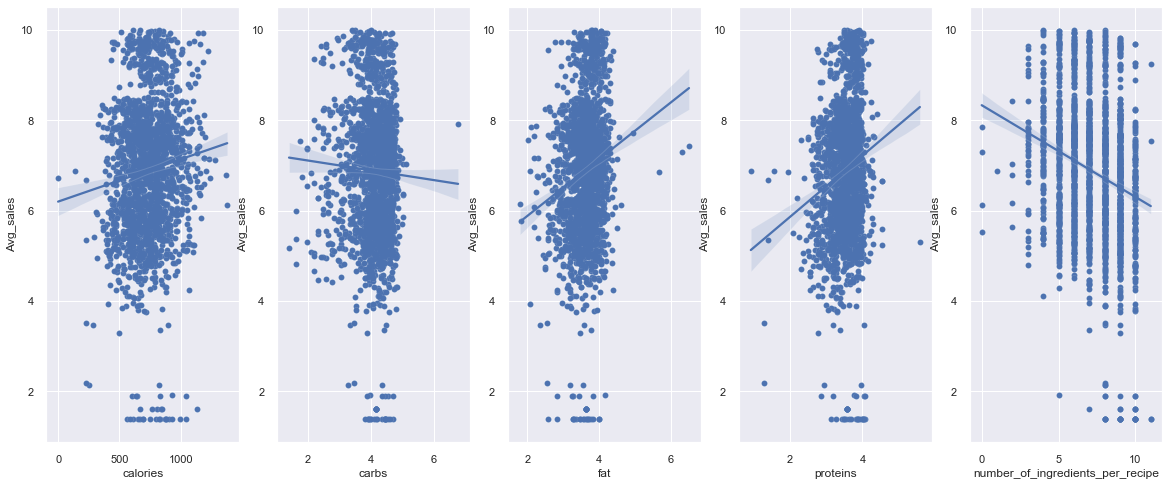

In [41]:
fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(figsize = (20,8), ncols=5)


## Scatter plotting 

sns.scatterplot( x = train_normal.calories, y = train_normal.Avg_sales,  ax=ax1)

## Putting a regression line. 

sns.regplot(x=train_normal.calories, y=train_normal.Avg_sales, ax=ax1)



## Scatter plotting  

sns.scatterplot( x = train_normal.carbs, y = train_normal.Avg_sales,  ax=ax2)

## Putting a regression line. 

sns.regplot(x=train_normal.carbs, y=train_normal.Avg_sales, ax=ax2)


## Scatter plotting 

sns.scatterplot(x = train_normal.fat,y = train_normal.Avg_sales, ax=ax3)

## regression line 

sns.regplot(x=train_normal.fat, y=train_normal.Avg_sales, ax=ax3);


## Scatter plotting 

sns.scatterplot(x = train_normal.proteins,y = train_normal.Avg_sales, ax=ax4)

## regression line

sns.regplot(x=train_normal.proteins, y=train_normal.Avg_sales, ax=ax4);


## Scatter plotting 

sns.scatterplot(x = train_normal.number_of_ingredients_per_recipe,y = train_normal.Avg_sales, ax=ax5)

## regression line

sns.regplot(x=train_normal.number_of_ingredients_per_recipe, y=train_normal.Avg_sales, ax=ax5);

**Observation**

- Even after the olog transformation wee were not able to observe majore  linear pattern between avg sales & other numeric features

#### Homoscedasticity 




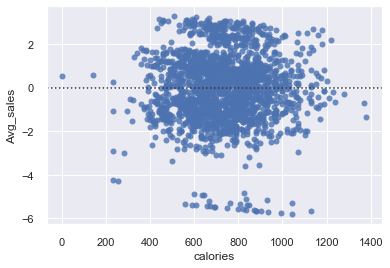

In [42]:
sns.residplot(x = train_normal.calories, y = train_normal.Avg_sales)

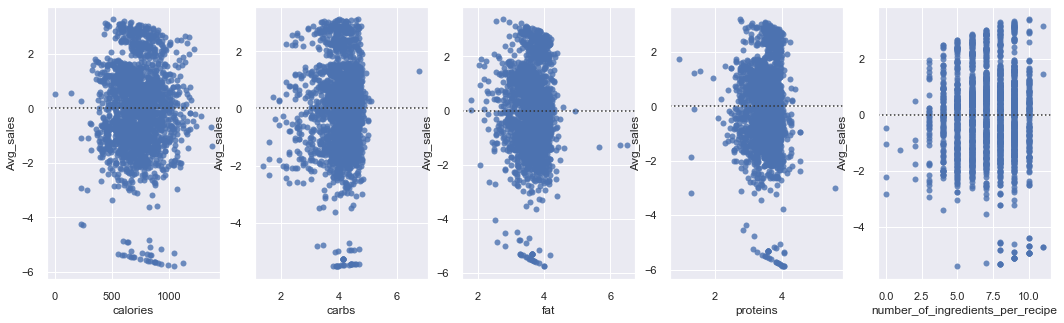

In [43]:
fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(figsize = (18,5), ncols=5)


sns.residplot(x = train_normal.calories, y = train_normal.Avg_sales,  ax=ax1);

sns.residplot(x = train_normal.carbs, y = train_normal.Avg_sales,  ax=ax2)

sns.residplot(x = train_normal.fat,y = train_normal.Avg_sales, ax=ax3)

sns.residplot(x = train_normal.proteins,y = train_normal.Avg_sales, ax=ax4)

sns.residplot(x = train_normal.number_of_ingredients_per_recipe,y = train_normal.Avg_sales, ax=ax5)



- post-transformed chart on the right has Homoscedasticity(almost an equal amount of variance across the zero lines). It looks like a blob of data points and doesn't seem to give away any relationships. That's the sort of relationship we would like to see to avoid some of these assumptions.

---------------------------------

#### No or Little multicollinearity



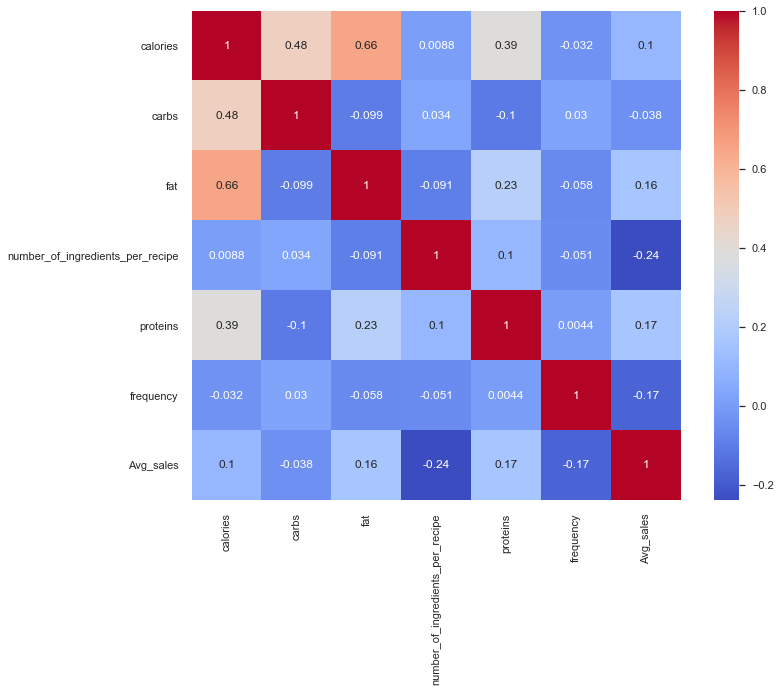

In [44]:
pd.set_option('display.max_columns', 7)
corrmat = train_normal[quantitative].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,square=True,annot=True,cmap= 'coolwarm');

**Observation**

- As we can see, the multicollinearity still exists in various features. However, we will keep them for now for the sake of learning and let the models(Lasso, Ridge) do the clean up later on.

#### Detecting Multicollinearity Using Variance Inflation Factors

A variance inflation factor(VIF) detects multicollinearity in regression analysis. VIF=1/(1-r2) A rule of thumb for interpreting the variance inflation factor: 1 = not correlated. Between 1 and 5 = moderately correlated. Between 5 and 10 = correlated Greater than 10 = highly correlated.

In [817]:
num_col = ['calories', 'carbs', 'fat', 'number_of_ingredients_per_recipe',
       'proteins']

len(num_col)

from statsmodels.stats.outliers_influence import variance_inflation_factor

x_features=list(Uni_train3[num_col])
data_mat = Uni_train3[x_features].values
vif = [ variance_inflation_factor( data_mat,i) for i in range(data_mat.shape[1]) ]
vif_factors = pd.DataFrame()
vif_factors['column'] = list(x_features)
vif_factors['vif'] = vif
vif_factors.sort_values(by=['vif'],ascending=False)

,column,vif
0,calories,34.053973
4,proteins,10.669884
3,number_of_ingredients_per_recipe,10.078800
1,carbs,7.571388
2,fat,4.972090


---------------------------------

## <a id='6'>6. Feature Engineering </a>

- Create dummy feature for the categorical varibles

In [45]:
df_train = train_normal[['product_type', 'calories','carbs', 'cooking_time','dish_type','fat','number_of_ingredients_per_recipe','proteins', 'meta_tags','protein_cuts','Avg_sales']]


In [46]:
cate_features = df_train[['product_type','cooking_time','dish_type','meta_tags','protein_cuts']]

one_hot = pd.get_dummies(cate_features[['product_type','cooking_time','dish_type','meta_tags','protein_cuts']])

df_train1 = df_train.drop(['product_type','cooking_time','dish_type','meta_tags','protein_cuts'], axis = 1)

----------------------------

- Mapping the dummy features along with numeric and preparing the base data for modeling

In [47]:

X= df_train1.drop(['Avg_sales'],axis=1)

y= df_train1['Avg_sales']

X = X.join(one_hot)


In [48]:
X = X[['calories', 'carbs', 'fat', 'number_of_ingredients_per_recipe','proteins', 'product_type_2 person', 'product_type_family', 'cooking_time_time_level_3','cooking_time_time_level_4', 'cooking_time_time_level_5','cooking_time_time_level_6', 'cooking_time_time_level_7',
'dish_type_fish', 'dish_type_meat', 'dish_type_veggie','meta_tags_healthy_choice', 'meta_tags_healthy_choice,kid_friendly','meta_tags_healthy_choice,kid_friendly,quick','meta_tags_healthy_choice,quick', 'meta_tags_kid_friendly','meta_tags_kid_friendly,healthy_choice', 'meta_tags_kid_friendly,quick',
'meta_tags_kid_friendly,quick,healthy_choice', 'meta_tags_quick','meta_tags_quick,healthy_choice', 'meta_tags_quick,kid_friendly','meta_tags_quick,kid_friendly,healthy_choice', 'protein_cuts_breast','protein_cuts_burger_patty', 'protein_cuts_chops_boneless','protein_cuts_drumsticks', 'protein_cuts_fillet','protein_cuts_ground_mince', 'protein_cuts_no_cut',
'protein_cuts_pulled_and_shaved', 'protein_cuts_sausage','protein_cuts_steak', 'protein_cuts_tenderloin','protein_cuts_thighs_bone_in_skin_on','protein_cuts_thighs_boneless_skinless']]

## <a id='7'>7. Implementataion of Machine Learning Models </a>

- Train & validation split along with Linear regression model

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

#### Linear regression model

In [50]:
linreg = LinearRegression()

#5 fold cross-validation r^2 mean score

linreg_scores = cross_val_score(linreg, X, y, cv=5)

# Fit the regression on Train dataset and check the score on both train and test dataset.

linreg.fit(X, y)

print(linreg.score(X_train, y_train))

# Test data #

linreg.score(X_test, y_test)

0.6030471686798946


0.600192253456362

In [51]:
linreg_predict = linreg.predict(X_test)

transformer=FunctionTransformer(inverse_func=np.exp)

pred_inv = transformer.inverse_transform(linreg_predict)

act_inv = transformer.inverse_transform(y_test)

predictions=pd.DataFrame(pred_inv)

predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index

predictions.rename(columns={0:'Pred'}, inplace=True)
predictions['Actual'] = act_inv

mse = mean_squared_error(predictions['Pred'], predictions['Actual'])
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 3481.175450


- Model seems to be working  fine on train & validation data with R2 of 60% for train & validation dataset. We have RMSE OF 3481



#### Lets test Regularization methods also,  find the best hyper parameters using grid search


####  Ridge  Regression Model

In [52]:
# Define the parameter values that should be searched

alpha_range = [1e-4, 1e-3, 1.5e-3, 1e-2, 1.5e-2, 1e-1, 1, 5, 10, 50, 100, 1000, 10000, 100000]
normalize_range = [True, False]
print(alpha_range, normalize_range)

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(alpha=alpha_range, normalize=normalize_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(Ridge(), param_grid, cv=5)
grid.fit(X, y)

# View best parameter
print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

[0.0001, 0.001, 0.0015, 0.01, 0.015, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000] [True, False]
{'alpha': [0.0001, 0.001, 0.0015, 0.01, 0.015, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000], 'normalize': [True, False]}
Best parameters set found on development set:

{'alpha': 0.0001, 'normalize': False}

Grid scores on development set:



In [53]:
# Run Ridge with optimized alpha and normalize parameters
ridge = Ridge(alpha=0.0001, normalize=False)

# Fit model
ridge.fit(X, y)

ridge_scores = cross_val_score(ridge, X, y, cv=5)

print(ridge.score(X_train, y_train))

# Test data #
ridge.score(X_test, y_test)

0.6030471438735601


0.6001923142547647

In [54]:
ridge_predict = ridge.predict(X_test)


transformer=FunctionTransformer(inverse_func=np.exp)

pred_inv = transformer.inverse_transform(ridge_predict)

act_inv = transformer.inverse_transform(y_test)

predictions=pd.DataFrame(pred_inv)

predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index

predictions.rename(columns={0:'Pred'}, inplace=True)
predictions['Actual'] = act_inv

mse = mean_squared_error(predictions['Pred'], predictions['Actual'])
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 3481.176047


- Model seems to be working  fine on train & validation data with R2 of 60% for train & validation dataset. We have RMSE OF 3481

#### Lasso  Regression Model

In [55]:
# Define the parameter values that should be searched
alpha_range = [1e-4, 1e-3, 1.5e-3, 1e-2, 1.5e-2, 1e-1, 1, 5, 10, 50, 100, 1000, 10000, 100000]
normalize_range = [True, False]
print(alpha_range, normalize_range)

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(alpha=alpha_range, normalize=normalize_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(Lasso(), param_grid, cv=5)
grid.fit(X, y)

# View best parameter
print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']

[0.0001, 0.001, 0.0015, 0.01, 0.015, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000] [True, False]
{'alpha': [0.0001, 0.001, 0.0015, 0.01, 0.015, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000], 'normalize': [True, False]}
Best parameters set found on development set:

{'alpha': 0.001, 'normalize': True}

Grid scores on development set:



In [56]:
# Run Lasso with optimized alpha and normalize parameters
lasso = Lasso(alpha=  0.001, normalize=True)

# Fit model
lasso.fit(X, y)

lasso_scores = cross_val_score(lasso, X, y, cv=5)


lasso.fit(X, y)

print(lasso.score(X, y))

# Test data #

lasso.score(X_test, y_test)

0.5483358207563251


0.5571176079767054

In [57]:
lasso_predict = lasso.predict(X_test)

transformer=FunctionTransformer(inverse_func=np.exp)

pred_inv = transformer.inverse_transform(lasso_predict)

act_inv = transformer.inverse_transform(y_test)

predictions=pd.DataFrame(pred_inv)

predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index

predictions.rename(columns={0:'Pred'}, inplace=True)
predictions['Actual'] = act_inv

mse = mean_squared_error(predictions['Pred'], predictions['Actual'])
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 3629.476789


- Model seems to be working not so good on train & validation data with R2 of 54% & 55% for train & validation dataset. We have RMSE OF 3629

#### Xgboost Regressor Model

In [58]:
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


In [59]:
xgb_fit = xgb.fit(X_train, y_train)

predict_xgb = xgb.predict(X_test)

print(xgb.score(X, y))

# Test data #
xgb.score(X_test, y_test)

[00:49:26] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:30] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
0.8059504734182626


0.6330467086788265

In [60]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt

transformer=FunctionTransformer(inverse_func=np.exp)

pred_inv = transformer.inverse_transform(predict_xgb)

act_inv = transformer.inverse_transform(y_test)

predictions=pd.DataFrame(pred_inv)

predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index

predictions.rename(columns={0:'Pred'}, inplace=True)
predictions['Actual'] = act_inv

mse = mean_squared_error(predictions['Pred'], predictions['Actual'])
rmse = sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 3469.273981


- Model seems to be working better on train & validation data with R2 of 80% & 63% for train & validation dataset. We have RMSE OF 3469. However the R2 varies a lot for this model.

- I have tested the model wityh lesser features as well, still not much improvement beyond this point

### Performance Evaluation

In [61]:
print('Root Mean Square Error Linreg test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, linreg_predict))))
print('Root Mean Square Error Ridge test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, ridge_predict))))
print('Root Mean Square Error Lasso test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, lasso_predict))))
print('Root Mean Square Error XGB test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict_xgb))))

Root Mean Square Error Linreg test = 0.9635027413095698
Root Mean Square Error Ridge test = 0.9635026680500713
Root Mean Square Error Lasso test = 1.0140784632260076
Root Mean Square Error XGB test = 0.9230659818297312


In [62]:
print('Root Mean Square for LR  = ' + str('3481'))
print('Root Mean Square for Ridge  = ' + str('3481'))
print('Root Mean Square for Lasso  = ' + str('3629'))
print('Root Mean Square for XGBR  = ' + str('3469'))

Root Mean Square for LR  = 3481
Root Mean Square for Ridge  = 3481
Root Mean Square for Lasso  = 3629
Root Mean Square for XGBR  = 3469


### After looking at the performance of all these models I will prefer to go ahead with Linear regression/Ridge, since RMSE is close to XGB and in XGB the model does not generalize well on validation dataset. However in multiple linear regression  / Ridge models has a better R2 between Train & Validation dataset 

####  Residual Analysis

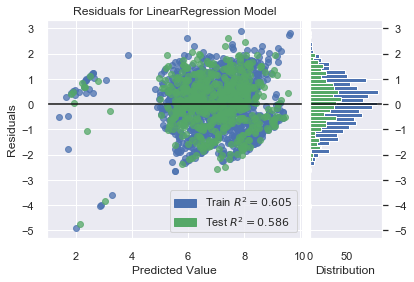

In [63]:

visualizer = ResidualsPlot(linreg)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 


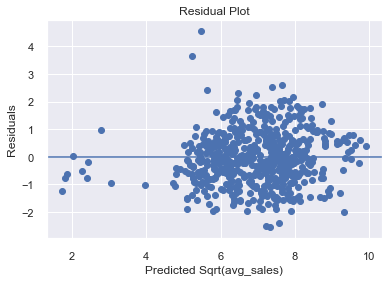

In [64]:
ridge_resid = (y_test) - (linreg_predict)
plt.scatter((predict_xgb), ridge_resid)

plt.title("Residual Plot")
plt.xlabel("Predicted Sqrt(avg_sales)")
plt.ylabel("Residuals")

plt.axhline(0)

- Relatively homoskedastic (still a bit of hetero in the beginning) - it's clear that there's less variance

-----------------------------------------


## <a id='8'>8. Submission @ Test Data </a>


In [65]:
test.head()

,year_week,recipe_id,recipe_name,...,percentage_of_local_ingredients,protein_cuts,sales
0,201945,38287,Juicy Lucy Meatloaf,...,0.0,ground_mince,NaN
1,201945,38309,Baja-Style Cauliflower Tacos,...,0.0,no_cut,NaN
2,201945,38310,Baja-Style Cauliflower Tacos,...,0.0,no_cut,NaN
3,201945,38311,Brown Butter Cheese Ravioli,...,0.0,no_cut,NaN
4,201945,38312,Brown Butter Cheese Ravioli,...,0.0,no_cut,NaN


- Create a copy of dataset and Implement the basic feature transformations

In [67]:
test1= test.copy()
FM_BASE = test1[['recipe_id','sales']]
FM_table = FM_BASE.groupby('recipe_id').agg({'recipe_id': lambda x: len(x)})
FM_table.rename(columns={ 'recipe_id': 'frequency'}, inplace=True)
FM_table.reset_index()


In [69]:
Uni_test1 = test1.drop(['year_week','sales'], axis = 1) 

Uni_test1 = Uni_test1.drop_duplicates()
Uni_test2 = pd.merge(Uni_test1, FM_table, on='recipe_id', how='inner')

In [70]:
total = Uni_test2.isnull().sum().sort_values(ascending=False)
percent = (Uni_test2.isnull().sum()/Uni_test2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(2)

,Total,Percent
cooking_tip,318,1.000000
seasons,224,0.704403


#### We will select the features  used in building our Base model

In [71]:

Uni_test3 = Uni_test2[['recipe_name','product_type', 'calories', 'carbs', 'cooking_time', 'dish_type', 'fat','number_of_ingredients_per_recipe', 'proteins', 'meta_tags','protein_cuts']]

In [72]:
def func2(a):
    
    if "Chicken" in a:
        return "breast"
    if "Beans" in a:
        return "kid_friendly"
    if "Bangers" in a:
        return "sausage"
    if "Thighs" in a:
        return "thighs_boneless_skinless"
    if "Chops" in a:
        return "chops_boneless"
    if "Pizza" in a:
        return "no_cut" 
    if "Steak" in a:
        return "steak"
    if "Spiced Chicken" in a:
        return "no_cut"
    if "Drumsticks" in a:
        return "drumsticks"
    if "Steak" in a:
        return "steak"
    if "Chicken Thighs" in a:
        return "thighs_bone_in_skin_on"
    if "Tso's" in a:
        return "no_cut"
    if "Patties" in a:
        return "burger_patty"
    if "Patties" in a:
        return "burger_patty"
    if "Steak" in a:
        return "steak"
    if "Turkey" in a:
        return "ground_mince"
    if "Sweet Potatoes" in a:
        return "no_cut"
    if "Pork Chops" in a:
        return "chops_boneless"
    if "Pork Cutlets" in a:
        return "tenderloin"
    if "Herb" in a:
        return "steak"
    if "Steak" in a:
        return "steak"
    if "Veggie" in a:
        return "no_cut"
    if "Meatballs" in a:
        return "ground_mince"
    
    else:
        return 0
Uni_test3["protein_c"] = Uni_test3.recipe_name.apply(lambda x: func2(x))

Uni_test3['protein_cuts'] = Uni_test3['protein_cuts'].fillna(0)

Uni_test3['protein_cuts'] = Uni_test3.apply(lambda x: x['protein_c'] if x['protein_cuts']== 0 else x['protein_cuts'], axis=1)

Uni_test3 = Uni_test3.drop(['protein_c',],axis=1)

Uni_test3['protein_cuts']=Uni_test3['protein_cuts'].replace(0, np.nan)

columns_None = ['protein_cuts']
Uni_test3[columns_None]= Uni_test3[columns_None].fillna('no_cut')


In [73]:
def func1(a):
    
    if "Stew" in a:
        return "healthy_choice,quick"
    if "Spiced Chicken" in a:
        return "kid_friendly"
    if "Steak" in a:
        return "healthy_choice,quick"
    if "Ravioli" in a:
        return "kid_friendly,quick"
    if "Creamy Carbonara" in a:
        return "kid_friendly,quick"
    if "Garlic Chicken" in a:
        return "thighs_boneless_skinless" 
    if "Chicken" in a:
        return "healthy_choice,quick"
    if "Steak & Crispy" in a:
        return "quick"
    if "Drumsticks" in a:
        return "kid_friendly"
    if "Enchiladas" in a:
        return "kid_friendly,quick"
    if "Bangers and Mash" in a:
        return "kid_friendly"
    if "Burger" in a:
        return "kid_friendly"
    if "Pizza" in a:
        return "kid_friendly"
    if "Macaroni" in a:
        return "kid_friendly"
    if "Meatloaves" in a:
        return "kid_friendly"
    if "Cheeseburgers" in a:
        return "kid_friendly"
    
    if "Flatbread" in a:
        return "kid_friendly"
    if "Vegetables" in a:
        return "healthy_choice,quick"
    if "Oat" in a:
        return "healthy_choice,quick"
    if "Cauliflower" in a:
        return "healthy_choice,quick"
    if "Sausage" in a:
        return "healthy_choice,quick"
    if "Cookies" in a:
        return "kid_friendly"
    if "Udon" in a:
        return "healthy_choice,quick"
    if "Gnocchi" in a:
        return "healthy_choice,quick"
    if "Ramen" in a:
        return "healthy_choice,quick"
    if "Cake" in a:
        return "kid_friendly"
    if "Veggie" in a:
        return "healthy_choice,quick"
    if "Spinach" in a:
        return "healthy_choice,quick"
    
    if "Meatballs" in a:
        return "healthy_choice,quick"
    if "Beef" in a:
        return "healthy_choice,quick"
    if "Salmon" in a:
        return "healthy_choice"
    if "Tofu" in a:
        return "healthy_choice,quick"
    if "Carrot" in a:
        return "healthy_choice,quick"
    if "Beef" in a:
        return "healthy_choice,quick"
    if "Ratatouille" in a:
        return "kid_friendly"
    if "Seared Sirloin Steaks" in a:
        return "quick,kid_friendly"
    if "Potato" in a:
        return "quick,kid_friendly"
    if "Pie" in a:
        return "quick"
    if "Pork" in a:
        return "healthy_choice,quick"
    if "Salad" in a:
        return "healthy_choice,quick"
    if "Soup" in a:
        return "healthy_choice,quick"
    if "Vegetarian" in a:
        return "healthy_choice"
    if "Shrimp" in a:
        return "kid_friendly,healthy_choice,quick"
    if "Mozzarella" in a:
        return "quick"
    if "Bean" in a:
        return "quick"
    if "Turkey" in a:
        return "healthy_choice,quick"
    if "Tacos" in a:
        return "kid_friendly,quick"
    if "Noodles" in a:
        return "healthy_choice"
    if "Tortelloni" in a:
        return "kid_friendly,quick"
    if "Herbed" in a:
        return "healthy_choice"
    if "Baked Cheesy" in a:
        return "kid_friendly,quick"
    if "Primavera" in a:
        return "quick"
    if "Lasagna" in a:
        return "kid_friendly,quick"
    if "Day" in a:
        return "healthy_choice,quick"
    if "Cod" in a:
        return "quick"
    if "Pasta" in a:
        return "quick"
    if "Risotto" in a:
        return "kid_friendly,quick"
    else:
        return 0
Uni_test3["meta_t"] = Uni_test3.recipe_name.apply(lambda x: func1(x))

Uni_test3['meta_tags'] = Uni_test3['meta_tags'].fillna(0)

Uni_test3['meta_tags'] = Uni_test3.apply(lambda x: x['meta_t'] if x['meta_tags']== 0 else x['meta_tags'], axis=1)

Uni_test3 = Uni_test3.drop(['meta_t',],axis=1)


In [74]:
#fill missing values for each column (using its own most frequent value)

columns_with_NA = ['cooking_time']

Uni_test3[columns_with_NA] = Uni_test3[columns_with_NA].fillna(Uni_test3.mode().iloc[0])

In [75]:

df_test = Uni_test3[['product_type', 'calories','carbs', 'cooking_time','dish_type','fat',
                     'number_of_ingredients_per_recipe','proteins', 'meta_tags','protein_cuts']]


In [76]:
cate_features = df_test[['product_type','cooking_time','dish_type','meta_tags','protein_cuts']]

one_hot = pd.get_dummies(cate_features[['product_type','cooking_time','dish_type','meta_tags','protein_cuts']])

df_test1 = df_test.drop(['product_type','cooking_time','dish_type','meta_tags','protein_cuts'], axis = 1)

In [77]:
X_sub = df_test1.join(one_hot)
X_sub = X_sub[X_train.columns]
predict_sub = xgb.predict(X_sub)

In [78]:
transformer=FunctionTransformer(inverse_func=np.exp)

pred_inv = transformer.inverse_transform(predict_sub)

predictions_sub =pd.DataFrame(pred_inv)

predictions_sub.reset_index(drop=True, inplace=True)

predictions_sub.index=X_sub.index

predictions_sub.rename(columns={0:'Predicted_sales'}, inplace=True)
predictions_sub1 = Uni_test2.merge(predictions_sub, left_index=True, right_index=True)

### Dataset for Final Submission

In [79]:

Final_Submission = pd.merge(test[['year_week','recipe_id']], predictions_sub1[['recipe_id','Predicted_sales']], on='recipe_id')

In [80]:
Final_Submission.to_csv('Final_Submission.csv')

In [81]:
Final_Submission.head()

,year_week,recipe_id,Predicted_sales
0,201945,38287,1033.174194
1,201945,38309,1025.175049
2,201945,38310,162.204773
3,201945,38311,2464.437988
4,201945,38312,546.448547


--------------------------------